# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [2]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int32 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int32(1), int64(1), object(2)
memory usage: 1.2+ MB


In [3]:
print(f"Number of Null email values is: ")

Number of Null email values is: 


In [4]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [5]:
# 1. Handle missing values
print(f"\nNumber of Null email values: {df.email.isna().sum()}")

# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')


Number of Null email values: 17


In [6]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [7]:
# What are the descriptive statistics of the number of articles a user interacts with?
# Count interactions per user
user_interactions = df.groupby('email').size()
article_interactions = df.groupby('article_id').size()

# Descriptive statistics
print(f"User interactions - Mean: {user_interactions.mean():.2f}, Median: {user_interactions.median()}")
print(f"Article interactions - Mean: {article_interactions.mean():.2f}, Median: {article_interactions.median()}")

User interactions - Mean: 8.93, Median: 3.0
Article interactions - Mean: 64.42, Median: 25.0


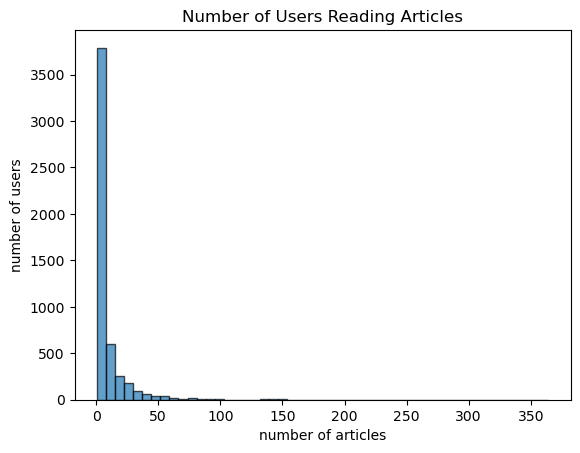

In [8]:
# Create a plot of the number of articles read by each user
plt.hist(user_interactions, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

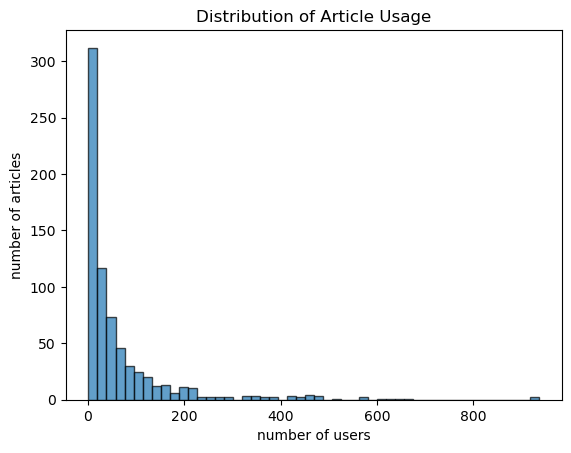

In [9]:
# Create a plot of the number of times each article was read
plt.hist(article_interactions, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [10]:
# Fill in the median and maximum number of user_article interactions below

median_val = int(user_interactions.median())  # 50% of individuals interact with ____ number of articles or fewer
max_views_by_user = int(user_interactions.max())  # The maximum number of user-article interactions by any 1 user

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
unique_articles = df['article_id'].nunique()  # Number of unique articles that have at least one interaction
total_articles = df['article_id'].nunique()  # Number of unique articles on the IBM platform (same as above)
unique_users = df['email'].nunique()  # Number of unique users (excluding null values after filling)
user_article_interactions = len(df)  # Number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
most_viewed_article_id = df.groupby('article_id').size().idxmax()  # Most viewed article ID as string
max_views = df.groupby('article_id').size().max()   # How many times most viewed article was viewed

In [13]:
print(f"\n--- Key Statistics ---")
print(f"Median interactions per user: {median_val}")
print(f"Max interactions by any user: {max_views_by_user}")
print(f"Total user-article interactions: {user_article_interactions}")
print(f"Most viewed article ID: {most_viewed_article_id}")
print(f"Most viewed article views: {max_views}")
print(f"Unique articles with interactions: {unique_articles}")
print(f"Unique users: {unique_users}")
print(f"Total unique articles: {total_articles}")


--- Key Statistics ---
Median interactions per user: 3
Max interactions by any user: 364
Total user-article interactions: 45993
Most viewed article ID: 1429
Most viewed article views: 937
Unique articles with interactions: 714
Unique users: 5149
Total unique articles: 714


In [14]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    """
    # Count interactions per article and get top n
    article_counts = df.groupby('title').size().sort_values(ascending=False)
    top_articles = article_counts.head(n).index.tolist()
    
    return top_articles

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    """
    # Count interactions per article_id and get top n
    article_counts = df.groupby('article_id').size().sort_values(ascending=False)
    top_articles = article_counts.head(n).index.tolist()
    
    return top_articles

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with
    an article and a 0 otherwise
    """
    # Create user-item matrix with 1s and 0s
    user_item = df.groupby(['user_id', 'article_id']).size().unstack(fill_value=fill_value)
    # Convert any non-zero values to 1 (in case of multiple interactions)
    user_item = (user_item > 0).astype(int)
    
    return user_item


user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    """
    # Get the user's row from the matrix
    user_row = user_item.loc[user_id].values.reshape(1, -1)
    
    # Compute cosine similarity with all users
    similarities = cosine_similarity(user_row, user_item.values)[0]
    
    # Get user indices sorted by similarity (descending)
    similar_indices = np.argsort(similarities)[::-1]
    
    # Get corresponding user_ids and similarities
    user_ids = user_item.index[similar_indices]
    similar_scores = similarities[similar_indices]
    
    # Remove the user itself
    mask = user_ids != user_id
    most_similar_users = user_ids[mask].tolist()
    most_similar_scores = similar_scores[mask].tolist()
    
    if include_similarity:
        return [[uid, sim] for uid, sim in zip(most_similar_users, most_similar_scores)]
    return most_similar_users

In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 4201, 46, 5034, 824, 253, 5041, 2305, 136, 395]
The 5 most similar users to user 3933 are: [1, 46, 4201, 824, 253]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [25]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids
    """
    # Get unique titles for the given article_ids
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    
    return article_names

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - (list) a list of article ids
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    ranked_article_unique_counts - (list) a list of tuples with article_id and number of
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    """
    # Filter for articles that exist in user_item matrix
    available_articles = [aid for aid in article_ids if aid in user_item.columns]
    
    # Get interaction counts for each article
    article_counts = []
    for article_id in available_articles:
        count = user_item[article_id].sum()
        article_counts.append([article_id, count])
    
    # Sort by count (descending)
    ranked_article_unique_counts = sorted(article_counts, key=lambda x: x[1], reverse=True)
    
    return ranked_article_unique_counts

def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids
    """
    # Get articles the user has interacted with (value = 1)
    user_articles = user_item.loc[user_id]
    article_ids = user_articles[user_articles == 1].index.tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names

def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    """
    # Get articles already seen by the user
    user_articles, _ = get_user_articles(user_id)
    user_articles_set = set(user_articles)
    
    # Get similar users
    similar_users = find_similar_users(user_id)
    
    recs = []
    
    # Iterate through similar users
    for similar_user in similar_users:
        if len(recs) >= m:
            break
            
        # Get articles this similar user has seen
        similar_user_articles, _ = get_user_articles(similar_user)
        
        # Find articles this similar user has seen but our user hasn't
        new_articles = [aid for aid in similar_user_articles if aid not in user_articles_set]
        
        # Add to recommendations
        for article in new_articles:
            if article not in recs:
                recs.append(article)
                if len(recs) >= m:
                    break
    
    return recs

In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['leverage python, scikit, and text classification for behavioral profiling',
 'challenges in deep learning',
 'awesome deep learning papers',
 'this week in data science (april 18, 2017)',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'this week in data science (may 2, 2017)',
 'using apply, sapply, lapply in r',
 'how can data scientists collaborate to build better business',
 'top 20 r machine learning and data science packages',
 'do i need to learn r?']

In [27]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles

    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
    """
    # Get similar users with similarities
    similar_users_with_sim = find_similar_users(user_id, include_similarity=True)
    
    # Create dataframe
    neighbors_df = pd.DataFrame(similar_users_with_sim, columns=['neighbor_id', 'similarity'])
    
    # Add number of interactions for each neighbor
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(
        lambda x: user_item.loc[x].sum()
    )
    
    # Sort by similarity (desc) then by num_interactions (desc)
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df

def user_user_recs_part2(user_id, m=10):
    """
    Improved user-user recommendations with better ranking
    """
    # Get articles already seen by the user
    user_articles, _ = get_user_articles(user_id)
    user_articles_set = set(user_articles)
    
    # Get top sorted similar users
    neighbors_df = get_top_sorted_users(user_id)
    
    # Collect all candidate articles with their popularity
    candidate_articles = {}
    
    for _, neighbor_row in neighbors_df.iterrows():
        neighbor_id = neighbor_row['neighbor_id']
        
        # Get articles this neighbor has seen
        neighbor_articles, _ = get_user_articles(neighbor_id)
        
        # Find new articles
        new_articles = [aid for aid in neighbor_articles if aid not in user_articles_set]
        
        # Add to candidates
        for article in new_articles:
            if article not in candidate_articles:
                candidate_articles[article] = user_item[article].sum()  # popularity count
    
    # Sort by popularity and take top m
    sorted_candidates = sorted(candidate_articles.items(), key=lambda x: x[1], reverse=True)
    recs = [article_id for article_id, _ in sorted_candidates[:m]]
    
    return recs, get_article_names(recs)

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330, 1429, 1364, 1314, 1398, 1431, 1271, 1427, 1160, 43]

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'insights from new york car accident reports', 'analyze accident reports on amazon emr spark', 'deep learning with tensorflow course by big data university', 'total population by country', 'customer demographics and sales']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
    neighbor_id  similarity  num_interactions
0          5083    0.730297                 5
1          1552    0.577350                 2
2          1890    0.577350                 2
3          1372    0.471405                 3
4          2941    0.433013                 8
21         3586    0.408248                 4
5           504    0.408248                 1
6           378    0.408248                 1
7           496    0.408248                 1
8          1585    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1         4459    0.388909                96
2          203    0.388909                96
3         3782    0.387585               135
4           40    0.384308                52
5         4932    0.384308                52
6           23    0.377647               135
7          242    0.375823                59

In [32]:
# Get specific users for solution 5
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']
user2_6th_sim = get_top_sorted_users(2).iloc[5]['neighbor_id']  # 6th most similar (index 5)
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']  # 10th most similar (index 9)

In [33]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

For a new user with no interaction history, we can only use rank-based recommendations (Part II). User-user collaborative filtering requires existing user interactions to find similar users, so it cannot be applied to cold-start users. The best approach for new users is to recommend the most popular articles based on overall interaction counts, which provides a reasonable starting point until the user begins interacting with articles and we can build a profile for collaborative filtering.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [35]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
print(f"\nRecommendations for new user: {new_user_recs}")


Recommendations for new user: [1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [36]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [37]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [40]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [38]:
# unique articles
df_unique_articles = df[['article_id', 'title']].drop_duplicates().reset_index(drop=True)
print(f"Unique articles: {len(df_unique_articles)}")

Unique articles: 714


In [41]:
# Create TF-IDF vectorizer
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)

print("Running TF-IDF...")
X_tfidf = vectorizer.fit_transform(df_unique_articles['title'])
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

# Apply LSA (Latent Semantic Analysis)
lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF...
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


C:\Users\amari\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\amari\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\amari\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\amari\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

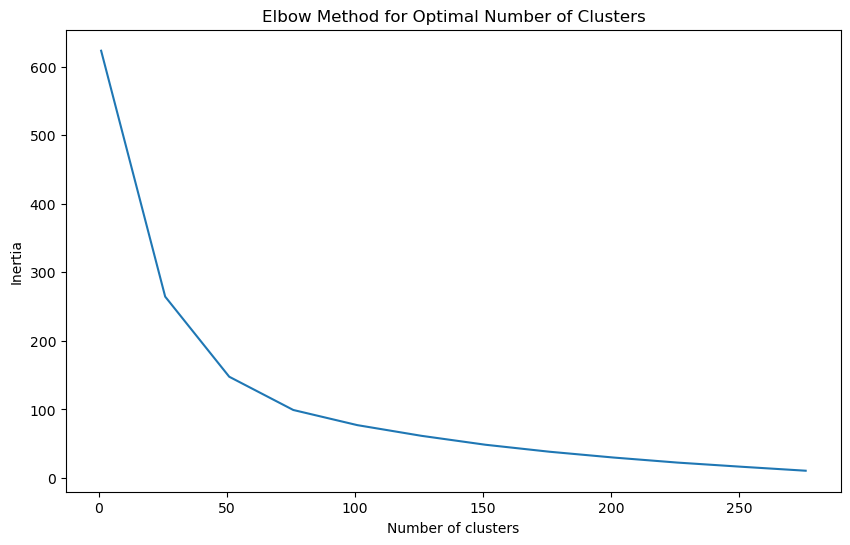

In [42]:
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42

for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

There appears to be an elbow about 50, so we'll use 50 clusters.

In [43]:
n_clusters = 50
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state,
).fit(X_lsa)

C:\Users\amari\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [44]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
# Create article-cluster mapping
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_))
df['title_cluster'] = df['article_id'].map(article_cluster_map)

In [45]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 66],
       [ 1, 20],
       [ 2, 38],
       [ 3, 18],
       [ 4, 23],
       [ 5,  9],
       [ 6, 20],
       [ 7, 37],
       [ 8, 16],
       [ 9, 13],
       [10, 15],
       [11,  5],
       [12, 31],
       [13,  8],
       [14, 27],
       [15, 12],
       [16, 21],
       [17,  8],
       [18, 21],
       [19, 12],
       [20, 11],
       [21, 10],
       [22, 10],
       [23, 15],
       [24,  7],
       [25,  8],
       [26,  6],
       [27,  5],
       [28, 11],
       [29,  8],
       [30, 10],
       [31,  8],
       [32, 27],
       [33,  6],
       [34, 14],
       [35,  7],
       [36, 11],
       [37,  8],
       [38, 15],
       [39,  8],
       [40, 10],
       [41,  9],
       [42,  8],
       [43,  9],
       [44,  5],
       [45,  7],
       [46,  7],
       [47,  9],
       [48, 10],
       [49, 15]], dtype=int64)

In [46]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    articles_in_cluster - (list) a list of article ids that are in the same title cluster
    """
    # Get the cluster for this article
    title_cluster = df[df['article_id'] == article_id]['title_cluster'].iloc[0]
    
    # Get all articles in the same cluster
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].unique().tolist()
    
    # Remove the input article
    if article_id in articles_in_cluster:
        articles_in_cluster.remove(article_id)
    
    return articles_in_cluster

In [47]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    """
    # Get similar articles in the same cluster
    similar_articles = get_similar_articles(article_id, df)
    
    # Rank them by popularity (interaction count)
    if similar_articles:
        ranked_similar = get_ranked_article_unique_counts(similar_articles, user_item)
        n_ranked_similar_articles = [article[0] for article in ranked_similar[:n]]
        n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)
    else:
        n_ranked_similar_articles = []
        n_ranked_article_names = []
    
    return n_ranked_similar_articles, n_ranked_article_names

In [48]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 237, 593, 349, 821, 464, 29, 1042, 693, 48]
['upload files to ibm data science experience using the command line', 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics', 'better together: spss and data science experience', 'experience iot with coursera', 'use ibm data science experience to read and write data stored on amazon s3', 'deep learning with data science experience', 'data tidying in data science experience', 'using rstudio in ibm data science experience', 'use ibm data science experience to detect time series anomalies', 'data science experience documentation']


In [49]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

The content-based recommendation system works by analyzing article titles using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert text into numerical features. The system then applies Latent Semantic Analysis (LSA) using TruncatedSVD to reduce dimensionality and capture semantic relationships between articles. K-means clustering (with 50 clusters) groups articles with similar content together based on their LSA representations.
When recommending articles similar to a given article, the system finds all articles in the same cluster and ranks them by popularity (number of unique user interactions). This approach captures semantic similarity between articles while ensuring popular content is prioritized.
Possible improvements:

Use more sophisticated text preprocessing (stemming, lemmatization)
Include article abstracts or full content instead of just titles
Implement more advanced NLP techniques like word embeddings or transformer models
Consider hybrid approaches combining content similarity with user preferences

Additional useful text data:

Article abstracts or summaries
Author information and expertise areas
Article categories/tags
User comments and reviews
Article difficulty level or target audience

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [50]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [51]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

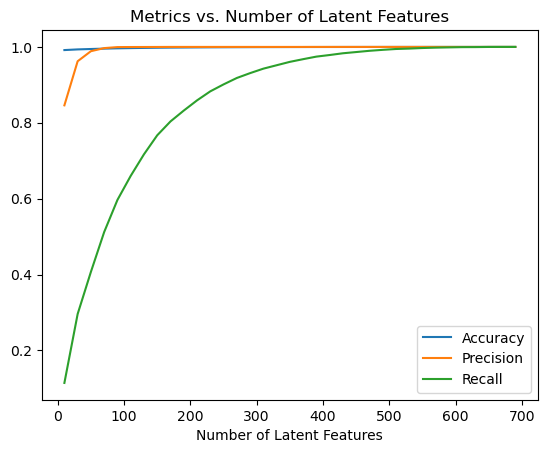

In [52]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

Based on the metrics plot, I would choose approximately 200 latent features. The plot shows that accuracy and precision plateau quickly around 50-100 features and remain stable thereafter. Recall continues to improve gradually but shows diminishing returns after 200 features.
Choosing 200 features provides a good balance between:

Computational efficiency (lower than the maximum 714 features)
Model performance (captures most of the meaningful patterns)
Avoiding overfitting (not using all available features)
Practical recommendations (sufficient complexity to capture user preferences)

The plateau in accuracy and precision suggests that additional features beyond 200 don't significantly improve the model's ability to reconstruct the user-item matrix accurately.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [53]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles
    include_similarity - (bool) whether to include the similarity in the output

    OUTPUT:
    most_similar_items - (list) a list of article ids similar using SVD factorization
    """
    # Find the index of the article_id in the user_item columns
    try:
        article_idx = list(user_item.columns).index(article_id)
    except ValueError:
        return []
    
    # Calculate cosine similarity - transpose vt to get 714 x features matrix
    vt_transposed = vt.T
    cos_sim = cosine_similarity(vt_transposed)
    
    # Get similarities for this article
    article_similarities = cos_sim[article_idx]
    
    # Sort by similarity (excluding the article itself)
    similar_indices = np.argsort(article_similarities)[::-1]
    
    # Remove the article itself
    similar_indices = similar_indices[similar_indices != article_idx]
    
    # Get corresponding article IDs
    most_similar_items = [user_item.columns[idx] for idx in similar_indices]
    most_similar_scores = [article_similarities[idx] for idx in similar_indices]
    
    if include_similarity:
        return [[aid, sim] for aid, sim in zip(most_similar_items, most_similar_scores)]
    return most_similar_items

In [54]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [55]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [56]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [57]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 'country statistics: crude oil - proved reserves',
 'country statistics: crude oil - exports',
 'top analytics tools in 2016',
 'advancements in the spark community',
 'airbnb data for analytics: paris calendar',
 'airbnb data for analytics: athens reviews']

In [58]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

The SVD-based recommendations for article 4 ("analyze ny restaurant data using spark in dsx") returned data science and analytics-focused articles, which shows the method captures relevant technical relationships.
Method Comparison and Testing:
Rank-Based (Part II): Best for new users with no history. Simple and interpretable but lacks personalization.
User-User Collaborative Filtering (Part III): Works well for users with interaction history. Captures user preferences but suffers from cold-start problems and sparsity issues.
Content-Based (Part IV): Good for finding topically similar articles. Works for any user but may create filter bubbles and struggles with content diversity.
Matrix Factorization (Part V): Captures latent factors and can handle sparse data well. Good for users with some history but requires sufficient data for training.
Testing Improvements:

A/B testing: Compare click-through rates and engagement metrics
Offline evaluation: Use train/test splits to measure precision@k, recall@k, and NDCG
User studies: Collect explicit feedback on recommendation quality
Business metrics: Track user retention, session duration, and content discovery

Situational Usage:

New users: Rank-based recommendations
Users with little history: Hybrid of rank-based + content-based
Users with rich history: User-user collaborative filtering + matrix factorization
Content discovery: Content-based for topic exploration
Overall system: Ensemble approach combining all methods with learned weights

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1